In [4]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from glob import glob
from depth_anything_v2 import dpt
from SuperGlue.models.matching import Matching
from dataclasses import dataclass

model_configs = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
    'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
    'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]}
}

encoder = 'vitb' 
dataset = 'hypersim' # 'hypersim' for indoor model, 'vkitti' for outdoor model
max_depth = 20 # 20 for indoor model, 80 for outdoor model

model = dpt.DepthAnythingV2(**{**model_configs[encoder], 'max_depth': max_depth})
model.load_state_dict(torch.load(f'./Models/depth_anything_v2_metric_{dataset}_{encoder}.pth', map_location='cpu'))

config = {
    'superpoint': {
        'nms_radius': 4,
        'keypoint_threshold': 0.005,
        'max_keypoints': 1024
    },
    'superglue': {
        'weights': 'indoor',
        'sinkhorn_iterations': 20,
        'match_threshold': 0.2,
    }
}

matching = Matching(config).eval().to(torch.device('cpu'))

@dataclass(frozen=True)
class iPhoneCamera():
    focal_length: float = 6.765 # mm
    camera_dpi: int = 732 # px / in
    focal_length_px: float = focal_length * camera_dpi / 25.4 
    scale: float = 4284 / 518 # px
    center: float = 4284 / 2

xFormers not available
xFormers not available


Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)


In [9]:
def img(path: str):
    image = cv2.imread(path)  # H, W, C
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (518,518), interpolation=cv2.INTER_CUBIC)
    return image

def get_images(prefix: str):
    return [img(f) for f in sorted(glob(f"./Images/{prefix}_*.jpg"))]

def preprocess_image_depth(image: np.ndarray):
    image = image / 255.0
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = (image-mean)/std
    image = np.transpose(image, (2,0,1)) # C, H, W
    return image

def preprocess_image_matcher(image: np.ndarray) -> torch.Tensor:
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = image / 255.0
    image = image.astype(np.float32)
    tensor = torch.from_numpy(image).float().to(torch.device('cpu')).unsqueeze(0).unsqueeze(0)
    return tensor

def postprocess_matches(pred: dict, num_matches: int = -1):
    pred = {k: v[0].cpu().numpy() for k, v in pred.items()}    
    kpts0, kpts1, matches, conf = pred['keypoints0'], pred['keypoints1'], pred['matches0'], pred['matching_scores0']

    valid = matches > -1
    mkpts0 = kpts0[valid]
    mkpts1 = kpts1[matches[valid]]
    mconf = conf[valid]

    idx = [x for x in range(len(mconf))]
    idx = sorted(idx, key=lambda x: mconf[x])[::-1][:num_matches]
    mkpts0 = np.array(mkpts0)[idx]
    mkpts1 = np.array(mkpts1)[idx]
    mconf = np.array(mconf)[idx]
    return mkpts0, mkpts1, mconf

def project_point(_x,_y,depth):
    z = depth[int(_y)][int(_x)]
    x = (((_x * iPhoneCamera.scale) - iPhoneCamera.center) * z / iPhoneCamera.focal_length_px)
    y = (((_y * iPhoneCamera.scale) - iPhoneCamera.center) * z / iPhoneCamera.focal_length_px)
    return x,y,z

def get_transform_3d(kpts0, kpts1, depth0, depth1):
    pts0 = np.array([project_point(a,b, depth0) for a,b in kpts0])
    pts1 = np.array([project_point(a,b, depth1) for a,b in kpts1])

    centroid0 = np.mean(pts0, axis=0)
    centroid1 = np.mean(pts1, axis=0)
    pts0_centered = pts0 - centroid0
    pts1_centered = pts1 - centroid1

    H = np.dot(pts0_centered.T, pts1_centered)

    U, S, Vt = np.linalg.svd(H)

    R = np.dot(Vt.T, U.T)
    if np.linalg.det(R) < 0:
        Vt[2, :] *= -1
        R = np.dot(Vt.T, U.T)

    t = centroid1 - np.dot(R, centroid0)
    return R, t

def decompose_rotation_matrix(R):
    sy = np.sqrt(R[0, 0] ** 2 + R[1, 0] ** 2)
    singular = sy < 1e-6

    if not singular:
        x = np.arctan2(R[2, 1], R[2, 2])
        y = np.arctan2(-R[2, 0], sy)
        z = np.arctan2(R[1, 0], R[0, 0])
    else:
        x = np.arctan2(-R[1, 2], R[1, 1])
        y = np.arctan2(-R[2, 0], sy)
        z = 0

    return np.array([x, y, z])

def nerf_inputs(transforms):
    positions = [np.array([0, 0, 0])]  
    directions = [np.array([0, 0, 1])]  

    for R, t in transforms:
        positions.append(positions[-1] + t)
        directions.append(np.dot(R, directions[-1]))

    

    return positions, directions

def get_depth(image: np.ndarray, model: torch.nn.Module):
    input_image = torch.from_numpy(image).unsqueeze(0).to(torch.float32).to(torch.device("cpu"))
    with torch.no_grad():
        depth = model.forward(input_image).squeeze()
        return depth
    
def get_matches(inputs: list[np.ndarray], model: Matching):
    matches = []
    for i in range(len(inputs) - 1):
        with torch.no_grad():
            pred = model({'image0': inputs[i], 'image1': inputs[i+1]})
            matches.append(postprocess_matches(pred=pred, num_matches=30))
    return matches

def depth_to_pcd(depth: torch.Tensor):
    pcd = []
    for _y in range(518):
        for _x in range(518):
            pcd.append((project_point(_x,_y, depth)))
    return pcd


In [10]:
images = get_images("indoor1")
match_inputs = [preprocess_image_matcher(x) for x in images]
depth_inputs = [preprocess_image_depth(x) for x in images]
depths = [get_depth(image=x, model=model) for x in depth_inputs]
matches = get_matches(inputs=match_inputs, model=matching)
transforms = [get_transform_3d(m[0], m[1], depths[i], depths[i+1]) for i,m in enumerate(matches)]
angles = [np.degrees(decompose_rotation_matrix(t[0])) for t in transforms]
positions,directions = nerf_inputs(transforms=transforms)

In [17]:
for row in angles: 
    x,y,z = row
    print("{: <15}".format(f"x deg {round(x,3)}") + "{: <15}".format(f"y deg {round(y,3)}") + "{: <15}".format(f"z deg {round(z,3)}"))

x deg 0.005    y deg -0.889   z deg -6.977   
x deg -0.144   y deg -1.528   z deg -7.406   
x deg 0.124    y deg -1.642   z deg -14.916  
x deg 0.5      y deg -1.974   z deg -11.632  
x deg 0.394    y deg -0.832   z deg -7.404   


In [18]:
for t in transforms:
    print(t[1])

[-13.149387     1.2709836   -0.17142439]
[-17.18032    2.149604   0.064955]
[-18.627024     3.630495    -0.23122978]
[-16.23209      2.2404919   -0.26518273]
[-13.068634     2.5146809   -0.02382898]


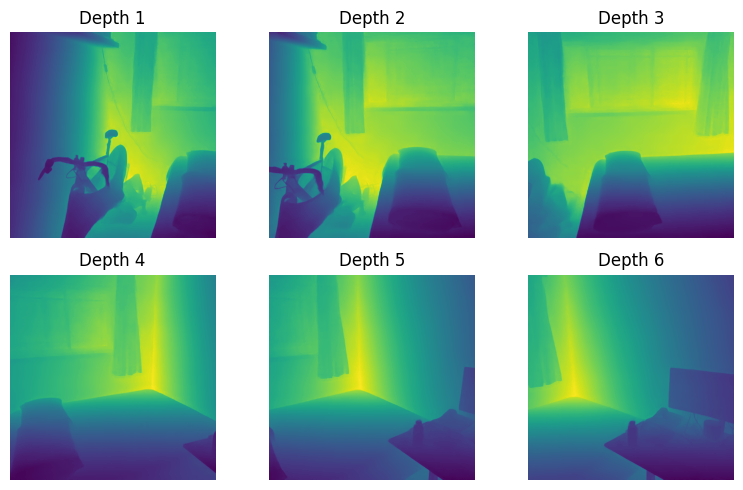

In [25]:
def plot_depth_images(depths):
    num_images = len(depths)
    cols = int(np.ceil(np.sqrt(num_images)))
    rows = int(np.ceil(num_images / cols))
    fig, axs = plt.subplots(rows, cols, figsize=(8, 5))
    
    axs = np.array(axs).reshape(-1)
    
    for i, depth in enumerate(depths):
        ax = axs[i]
        ax.imshow(depth)
        ax.set_title(f'Depth {i+1}')
        ax.axis('off')
    
    for ax in axs[len(depths):]:
        ax.axis('off')
    
    plt.tight_layout()
    return fig

fig = plot_depth_images(depths)
plt.show(fig)

In [31]:
def plot_results(imgs, mkpts0, mkpts1):
    n = len(mkpts0)    
    color = matplotlib.cm.gist_rainbow(np.linspace(start=0, stop=1.0, num=n))
    np.random.shuffle(color)

    linecolor = [(r, g, b, 0.5) for r, g, b, _ in color]

    fig, ax = plt.subplots(1, 2, figsize=(10,5), dpi=100)
    for i in range(2):
        ax[i].imshow(imgs[i])
        ax[i].set_aspect('equal')
        ax[i].get_yaxis().set_ticks([])
        ax[i].get_xaxis().set_ticks([])

    plt.tight_layout()

    norm = fig.transFigure.inverted()
    fig_coords_mkpts0 = norm.transform(ax[0].transData.transform(mkpts0))
    fig_coords_mkpts1 = norm.transform(ax[1].transData.transform(mkpts1))

    fig.lines.clear()

    for i in range(len(fig_coords_mkpts0)):
        line = matplotlib.lines.Line2D(
            xdata=[fig_coords_mkpts0[i, 0], fig_coords_mkpts1[i, 0]], 
            ydata=[fig_coords_mkpts0[i, 1], fig_coords_mkpts1[i, 1]],  
            transform=fig.transFigure,  
            color=linecolor[i],  
            linewidth=1
        )
        fig.lines.append(line)

    ax[0].scatter(mkpts0[:, 0], mkpts0[:, 1], c=color, s=6)
    ax[1].scatter(mkpts1[:, 0], mkpts1[:, 1], c=color, s=6)
    return fig

# uncomment this line to visually validate results
# figs = [plot_results((images[i], images[i+1]), m[0], m[1]) for i,m in enumerate(matches)]